In [1]:
# load libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# load all data (2014-2022)
meps = pd.read_csv("data/integrated_data.csv")

In [44]:
# randomly sample rows from dataset to make model more manageable
meps = meps.sample(n=100000, random_state=42)

In [46]:
# remove rows with Inf (had division by zero due to unexpected zeros)
meps = meps[~meps.isin([np.inf, -np.inf]).any(axis=1)]

In [18]:
# view columns
print(meps.columns)

Index(['Unnamed: 0', 'Person.ID', 'Drug', 'Quantity', 'Strength', 'Day_Supply',
       'Daily_Frequency', 'Daily_Dosage', 'Year', 'Age', 'Sex', 'Ethnicity',
       'Race', 'Personal_income', 'Family_income', 'Poverty_category',
       'Can.t_get_PMED', 'Insurance_coverage', 'PMED_insurance_coverage',
       'Concentration'],
      dtype='object')


In [47]:
# fix columns with apostrophe
meps.rename(columns=lambda x: x.replace("'", "_"), inplace=True)

In [7]:
# view columns
print(meps.columns)

Index(['Unnamed: 0', 'Person.ID', 'Drug', 'Quantity', 'Strength', 'Day_Supply',
       'Daily_Frequency', 'Daily_Dosage', 'Year', 'Age', 'Sex', 'Ethnicity',
       'Race', 'Personal_income', 'Family_income', 'Poverty_category',
       'Can.t_get_PMED', 'Insurance_coverage', 'PMED_insurance_coverage',
       'Concentration'],
      dtype='object')


In [48]:
# drop columns not needed for random forest model
meps = meps.drop(['Unnamed: 0', 'Person.ID', 'Quantity',
                  'Strength',"Day_Supply",'Daily_Frequency', 'Daily_Dosage',
                  'Concentration'], axis=1)

In [21]:
meps.head(10)

,Drug,Age,Sex,Ethnicity,Race,Personal_income,Family_income,Poverty_category,Can.t_get_PMED,Insurance_coverage,PMED_insurance_coverage
0,desoximetasone,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0
1,desoximetasone,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0
2,desoximetasone,30.0,2.0,4.0,4.0,0.0,100000.0,5.0,2.0,1.0,1.0
3,desoximetasone,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
4,desoximetasone,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
5,desoximetasone,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
6,desoximetasone,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
7,desoximetasone,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
8,desoximetasone,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
9,desoximetasone,46.0,2.0,3.0,2.0,52000.0,52000.0,5.0,2.0,1.0,1.0


In [49]:
# encode Drug variable
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
meps['Drug'] = encoder.fit_transform(meps['Drug'])
meps.head(10)

,Drug,Year,Age,Sex,Ethnicity,Race,Personal_income,Family_income,Poverty_category,Can.t_get_PMED,Insurance_coverage,PMED_insurance_coverage
0,107,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0
1,107,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0
2,107,2014,30.0,2.0,4.0,4.0,0.0,100000.0,5.0,2.0,1.0,1.0
3,107,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
4,107,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
5,107,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
6,107,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
7,107,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
8,107,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
9,107,2014,46.0,2.0,3.0,2.0,52000.0,52000.0,5.0,2.0,1.0,1.0


In [23]:
# check # of unique drugs
unique_drug_num = meps['Drug'].nunique()
print(unique_drug_num)

416


NOTE: may be good to check for relationships between variables to avoid overfitting

In [50]:
# reserve 2022 for model internal validation
meps_2022 = meps[meps['Year'] == 2022]
meps = meps[meps['Year'] != 2022]

In [53]:
# drop Year
meps_2022 = meps_2022.drop('Year',axis=1)

In [54]:
# split into train and test sets
from sklearn.model_selection import train_test_split
X = meps.drop(meps.columns[0], axis=1)
y = meps['Drug']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape, y_test.shape)

(705223, 10) (176306, 10)
(705223,) (176306,)


In [30]:
X.head(10)

,Age,Sex,Ethnicity,Race,Personal_income,Family_income,Poverty_category,Can.t_get_PMED,Insurance_coverage,PMED_insurance_coverage
0,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0
1,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0
2,30.0,2.0,4.0,4.0,0.0,100000.0,5.0,2.0,1.0,1.0
3,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
4,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
5,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
6,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
7,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
8,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0
9,46.0,2.0,3.0,2.0,52000.0,52000.0,5.0,2.0,1.0,1.0


Random forest with random search.

In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(
    n_estimators=100
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.13      0.20      0.16       586
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         0
           3       0.28      0.34      0.31       178
           4       0.07      0.50      0.12         2
           5       0.35      0.26      0.30      6103
           6       0.25      0.26      0.25       593
           7       0.19      0.27      0.23        26
           8       0.16      0.17      0.16      1109
           9       0.14      0.20      0.17        10
          10       0.29      0.21      0.24      1953
          11       0.32      0.32      0.32        19
          12       0.10      0.11      0.10       220
          13       0.15      0.19      0.17       528
          14       0.21      0.19      0.20      6249
          15       0.10      0.12      0.11        52
          16       0.23      0.33      0.27      1007
          18       0.21    

C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classificat

In [32]:
# feature importance analysis
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

                   Feature  Importance
5            Family_income    0.348658
4          Personal_income    0.292274
0                      Age    0.210479
6         Poverty_category    0.037844
9  PMED_insurance_coverage    0.032601
8       Insurance_coverage    0.030038
2                Ethnicity    0.016029
3                     Race    0.013800
7           Can.t_get_PMED    0.011639
1                      Sex    0.006636


In [55]:
# internal validation with 2022 data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# split 2022 data into X and y variables
X_int = meps_2022.drop(meps_2022.columns[0], axis=1)
y_int = meps_2022['Drug']

# implement model from random search
model.fit(X_int, y_int)

y_pred_int = model.predict(X_int)

print(classification_report(y_pred_int, y_int))

              precision    recall  f1-score   support

           0       0.26      0.32      0.28       511
           3       0.32      0.53      0.40       198
           4       0.20      1.00      0.33         1
           5       0.46      0.37      0.41      6175
           6       0.30      0.43      0.36       395
           8       0.26      0.31      0.28      1045
          10       0.33      0.32      0.32      1217
          12       0.19      0.28      0.23        89
          13       0.32      0.32      0.32       684
          14       0.33      0.33      0.33      6260
          15       0.08      0.56      0.14         9
          16       0.44      0.68      0.53       838
          18       0.82      0.64      0.72        14
          19       0.48      0.42      0.45       274
          20       0.40      0.28      0.33      2474
          21       0.19      0.30      0.23       321
          22       0.14      0.24      0.18       934
          23       0.37    

C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1

In [56]:
meps_2022.head(10)

,Drug,Age,Sex,Ethnicity,Race,Personal_income,Family_income,Poverty_category,Can.t_get_PMED,Insurance_coverage,PMED_insurance_coverage
881577,262,77.0,2.0,3.0,2.0,22000.0,22000.0,3.0,2.0,6.0,2.0
881578,262,77.0,2.0,3.0,2.0,22000.0,22000.0,3.0,2.0,6.0,2.0
881579,262,85.0,2.0,2.0,1.0,15119.0,15119.0,2.0,2.0,5.0,2.0
881580,262,85.0,2.0,2.0,1.0,15119.0,15119.0,2.0,2.0,5.0,2.0
881581,262,85.0,2.0,2.0,1.0,15119.0,15119.0,2.0,2.0,5.0,2.0
881582,262,85.0,2.0,2.0,1.0,15119.0,15119.0,2.0,2.0,5.0,2.0
881583,262,78.0,2.0,3.0,2.0,5000.0,5000.0,1.0,2.0,4.0,2.0
881584,262,78.0,2.0,3.0,2.0,5000.0,5000.0,1.0,2.0,4.0,2.0
881585,262,78.0,2.0,3.0,2.0,5000.0,5000.0,1.0,2.0,4.0,2.0
881586,262,63.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0


In [ ]:
# implement random forest classifier (without random search)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        90
           2       1.00      1.00      1.00         1
           3       1.00      0.78      0.88        23
           5       0.99      1.00      1.00       542
           6       0.98      0.90      0.94        63
           7       0.00      0.00      0.00         3
           8       0.92      1.00      0.96       115
           9       1.00      0.50      0.67         2
          10       0.99      0.98      0.98       165
          12       0.92      0.86      0.89        14
          13       0.95      0.92      0.94        64
          14       0.99      1.00      0.99       664
          15       0.50      0.20      0.29         5
          16       0.92      0.98      0.95       170
          17       0.00      0.00      0.00         2
          18       0.82      0.72      0.77        25
          19       0.92      0.91      0.91

C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vama3024\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classificat

In [17]:
# decode Drug variable
encoded_drugs_pred = y_pred
decoded_drugs = encoder.inverse_transform(encoded_drugs_pred)

In [33]:
# test the impact of removing age from model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
X_a = X.drop('Age', axis=1)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_a, y)
y_pred_a = clf.predict(X_test_a)

# model evaluation
accuracy = accuracy_score(y_test_a, y_pred_a)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_a, y_pred_a))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00        23
           5       1.00      1.00      1.00       542
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00       115
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00       165
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00       664
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00       170
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00        25
          19       1.00      1.00      1.00

In [17]:
# test the impact of removing sex from model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
X_s = X.drop('Sex', axis=1)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_s, y)
y_pred_s = clf.predict(X_test_s)

# model evaluation
accuracy = accuracy_score(y_test_s, y_pred_s)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_s, y_pred_s))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00        23
           5       1.00      1.00      1.00       542
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00       115
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00       165
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00       664
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00       170
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00        25
          19       1.00      1.00      1.00

In [18]:
# test the impact of removing ethnicity from model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
X_e = X.drop('Ethnicity', axis=1)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_e, y)
y_pred_e = clf.predict(X_test_e)

# model evaluation
accuracy = accuracy_score(y_test_e, y_pred_e)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_e, y_pred_e))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00        23
           5       1.00      1.00      1.00       542
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00       115
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00       165
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00       664
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00       170
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00        25
          19       1.00      1.00      1.00

In [21]:
# test the impact of removing race from model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
X_r = X.drop('Race', axis=1)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_r, y)
y_pred_r = clf.predict(X_test_r)

# model evaluation
accuracy = accuracy_score(y_test_r, y_pred_r)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_r, y_pred_r))

Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60        90
           2       0.50      1.00      0.67         1
           3       0.62      0.57      0.59        23
           5       0.57      0.60      0.58       542
           6       0.47      0.57      0.52        63
           7       0.50      0.33      0.40         3
           8       0.48      0.53      0.50       115
           9       0.50      1.00      0.67         2
          10       0.53      0.58      0.55       165
          11       0.00      0.00      0.00         0
          12       0.28      0.50      0.36        14
          13       0.45      0.45      0.45        64
          14       0.54      0.57      0.56       664
          15       0.14      0.20      0.17         5
          16       0.83      0.74      0.78       170
          17       1.00      0.50      0.67         2
          18       0.46      0.52      0.49

c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Top 10 predicted drugs:             Drug  Count
0   atorvastatin    896
1     lisinopril    861
2      metformin    762
3  levothyroxine    744
4     amlodipine    704
5     metoprolol    587
6      albuterol    570
7     omeprazole    494
8     gabapentin    455
9       losartan    420
Top 10 actual drugs:             Drug  Count
0   atorvastatin    934
1     lisinopril    800
2  levothyroxine    737
3      metformin    726
4     amlodipine    664
5     metoprolol    589
6      albuterol    542
7     omeprazole    477
8     gabapentin    440
9       losartan    435


C:\Users\vgmay\AppData\Local\Temp\ipykernel_16580\4207922195.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Drug', data=top_10_preds, ax=axes[0], palette=color_dict)
C:\Users\vgmay\AppData\Local\Temp\ipykernel_16580\4207922195.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Drug', data=top_10_test, ax=axes[1], palette=color_dict)


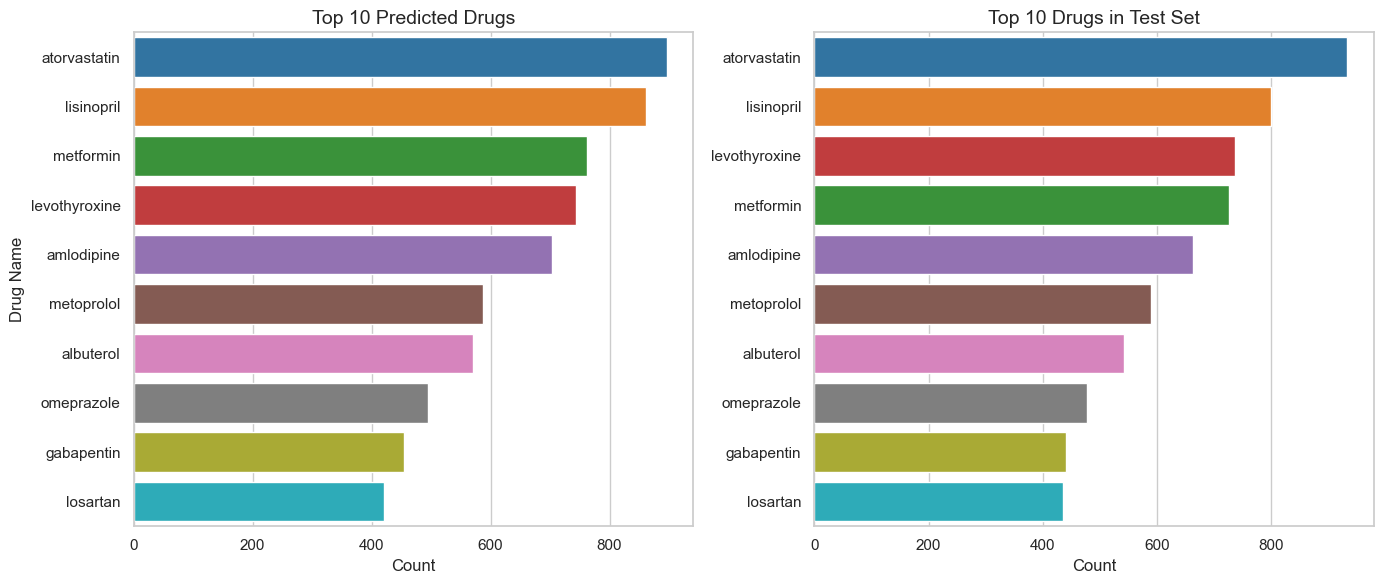

In [22]:
# NOTE: output from model with race removed is best model so far (model with ethnicity removed gives same metric scores), recall prioritized over precision

# plot side by side top 10 most frequently predicted drugs and top 10 most frequent drugs in test set
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# decode Drug variable
encoded_drugs_pred_r = y_pred_r
decoded_drugs_pred_r = encoder.inverse_transform(encoded_drugs_pred_r)

encoded_drugs_test_r = y_test_r
decoded_drugs_test_r = encoder.inverse_transform(encoded_drugs_test_r)

# Count occurrences
pred_counts = pd.Series(decoded_drugs_pred_r).value_counts().reset_index()
pred_counts.columns = ['Drug', 'Count']

test_counts = pd.Series(decoded_drugs_test_r).value_counts().reset_index()
test_counts.columns = ['Drug', 'Count']

top_10_preds = pred_counts.head(10)
top_10_test = test_counts.head(10)

print("Top 10 predicted drugs:", top_10_preds)
print("Top 10 actual drugs:", top_10_test)

# make color palette for drugs
all_drugs = pd.concat([top_10_preds['Drug'], top_10_test['Drug']]).drop_duplicates()
palette = sns.color_palette("tab10", n_colors=len(all_drugs))
color_dict = dict(zip(all_drugs, palette))

# Make the plot
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

sns.barplot(x='Count', y='Drug', data=top_10_preds, ax=axes[0], palette=color_dict)
axes[0].set_title('Top 10 Predicted Drugs', fontsize=14)
axes[0].set_xlabel('Count', fontsize=12)
axes[0].set_ylabel('Drug Name', fontsize=12)

sns.barplot(x='Count', y='Drug', data=top_10_test, ax=axes[1], palette=color_dict)
axes[1].set_title('Top 10 Drugs in Test Set', fontsize=14)
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_ylabel('')  

plt.tight_layout()
plt.show()

C:\Users\vgmay\AppData\Local\Temp\ipykernel_16580\1620963396.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Drug', y='Count', data=pred_counts, ax=axes[0], palette=color_dict2, width=0.9)
C:\Users\vgmay\AppData\Local\Temp\ipykernel_16580\1620963396.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Drug', y='Count', data=test_counts, ax=axes[1], palette=color_dict2, width=0.9)


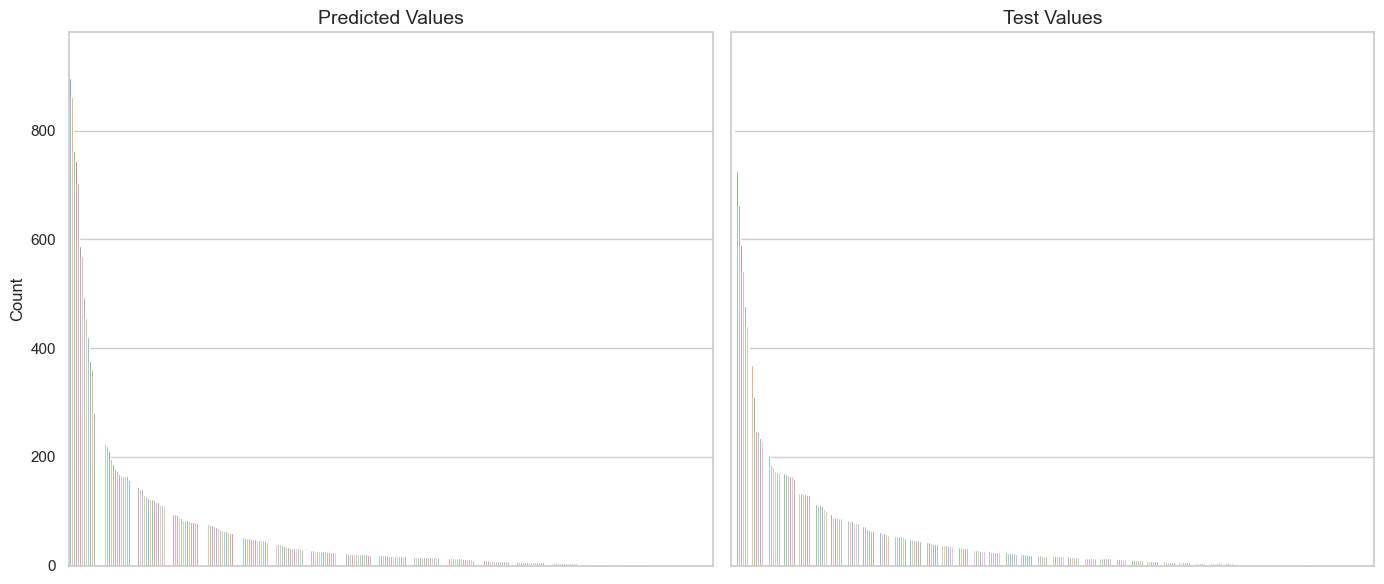

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Make color palette for drugs
all_drugs = pd.concat([pred_counts['Drug'], test_counts['Drug']]).unique()
palette = sns.color_palette("tab10", n_colors=len(all_drugs))
color_dict2 = dict(zip(all_drugs, palette))

# Create the plot
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.barplot(x='Drug', y='Count', data=pred_counts, ax=axes[0], palette=color_dict2, width=0.9)
axes[0].set_title('Predicted Values', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels([])  

sns.barplot(x='Drug', y='Count', data=test_counts, ax=axes[1], palette=color_dict2, width=0.9)
axes[1].set_title('Test Values', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels([])  

plt.tight_layout()
plt.show()

C:\Users\vgmay\AppData\Local\Temp\ipykernel_16580\3650793488.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sample', y='Match', data=comparison_df, ci=None)


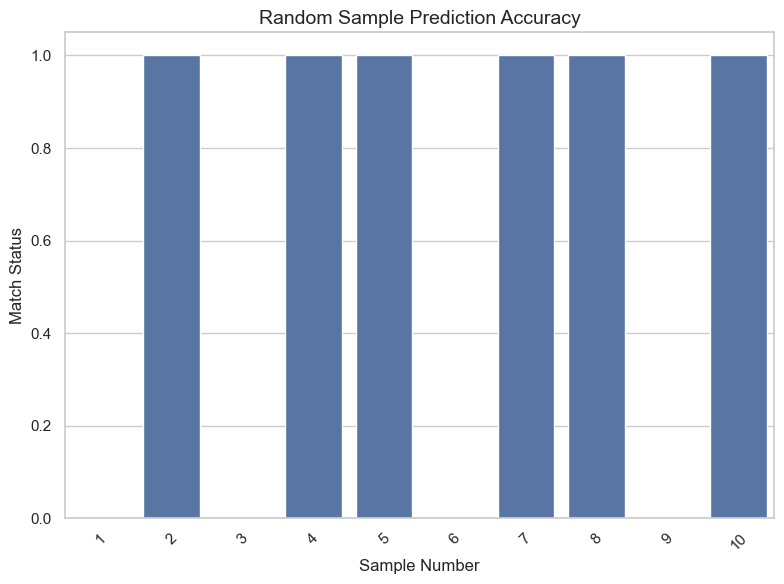

       Sample        Predicted                  Actual  Match
8070        1       amlodipine  isosorbide mononitrate      0
11984       2       lisinopril              lisinopril      1
11495       3      rizatriptan              clonazepam      0
12707       4  cyclobenzaprine         cyclobenzaprine      1
19813       5       topiramate              topiramate      1
4845        6     pantoprazole              furosemide      0
18164       7   spironolactone          spironolactone      1
8271        8      fenofibrate             fenofibrate      1
14117       9     pantoprazole               meloxicam      0
9919       10    ciprofloxacin           ciprofloxacin      1


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# convert drug arrays to dataframes
decoded_drugs_pred_r = pd.DataFrame(decoded_drugs_pred_r, columns=['Drug'])
decoded_drugs_test_r = pd.DataFrame(decoded_drugs_test_r, columns=['Drug'])

# Randomly sample 10 rows (same index from both predicted and test sets)
random_indices = np.random.choice(decoded_drugs_pred_r.index, 10, replace=False)
pred_sample = decoded_drugs_pred_r.loc[random_indices]
test_sample = decoded_drugs_test_r.loc[random_indices]

# Compare the predictions with the actual test values (1 for match, 0 for mismatch)
comparison = (pred_sample['Drug'] == test_sample['Drug']).astype(int)
comparison_df = pd.DataFrame({
    'Sample': np.arange(1, 11),
    'Predicted': pred_sample['Drug'],
    'Actual': test_sample['Drug'],
    'Match': comparison
})

# Plot the results
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(x='Sample', y='Match', data=comparison_df, ci=None)

plt.title('Random Sample Prediction Accuracy', fontsize=14)
plt.xlabel('Sample Number', fontsize=12)
plt.ylabel('Match Status', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(comparison_df)


In [34]:
# test the impact of removing personal & family income & poverty category from model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
columns_to_drop = ['Personal_income', 'Family_income', 'Poverty_category']
X_i = X.drop(columns=columns_to_drop)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_i, y)
y_pred_i = clf.predict(X_test_i)

# model evaluation
accuracy = accuracy_score(y_test_i, y_pred_i)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_i, y_pred_i))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00        23
           5       1.00      1.00      1.00       542
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00       115
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00       165
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00       664
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00       170
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00        25
          19       1.00      1.00      1.00

In [26]:
# test the impact of removing insurance coverage variables from model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
columns_to_drop = ['Can.t_get_PMED', 'Insurance_coverage', 'PMED_insurance_coverage']
X_c = X.drop(columns=columns_to_drop)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_c, y)
y_pred_c = clf.predict(X_test_c)

# model evaluation
accuracy = accuracy_score(y_test_c, y_pred_c)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_c, y_pred_c))

Accuracy: 0.55
Classification Report:


c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.64      0.57      0.60        90
           2       0.50      1.00      0.67         1
           3       0.62      0.57      0.59        23
           5       0.57      0.59      0.58       542
           6       0.50      0.57      0.53        63
           7       0.50      0.33      0.40         3
           8       0.47      0.54      0.50       115
           9       0.33      0.50      0.40         2
          10       0.54      0.58      0.56       165
          11       0.00      0.00      0.00         0
          12       0.27      0.50      0.35        14
          13       0.44      0.44      0.44        64
          14       0.53      0.57      0.55       664
          15       0.25      0.20      0.22         5
          16       0.83      0.74      0.78       170
          17       1.00      0.50      0.67         2
          18       0.43      0.52      0.47        25
          19       0.54    

c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

NOTE: The cells below are saved for later development. Several attempts were made to improve the model output before adjusting features, but their output was worse. The code is saved below to provide a reminder of what has been attempted so far and will be revisited after the conclusion of this class project.

In [27]:
# attempt with different hyperparameters and stratified K fold (NOTE: this output is worse, best output is above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

clf = RandomForestClassifier(random_state=42,n_estimators=300,max_depth=10, max_features='log2',min_samples_split=10)

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=skf)
print("Stratified K-Fold scores:", scores)

c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Stratified K-Fold scores: [0.08296332 0.08480339]


In [28]:
# Get predictions and accuracy after stratified K fold
all_predictions = []  
all_true_values = []  
fold_accuracies = []  

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    all_predictions.extend(y_pred)
    all_true_values.extend(y_test)
    
    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)

all_predictions = np.array(all_predictions)
all_true_values = np.array(all_true_values)

print("Fold Accuracies:", fold_accuracies)
print("Mean Accuracy:", np.mean(fold_accuracies))
print("All Predictions:", all_predictions)
print("All True Values:", all_true_values)    

c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fold Accuracies: [0.0829633185327413, 0.08480339213568543]
Mean Accuracy: 0.08388335533421337
All Predictions: [212  14 212 ... 212   5 368]
All True Values: [ 49  24  16 ...  49 252   0]


In [29]:
# attempt with original hyperparameters and stratified K hold (NOTE: first attempt is still the best output)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

clf = RandomForestClassifier(random_state=42)

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=skf)
print("Stratified K-Fold scores:", scores)

c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Stratified K-Fold scores: [0.14148566 0.14026561]


In [30]:
# Get predictions and accuracy after stratified K fold
all_predictions = [] 
all_true_values = []  
fold_accuracies = []  

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    all_predictions.extend(y_pred)
    all_true_values.extend(y_test)
    
    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)

all_predictions = np.array(all_predictions)
all_true_values = np.array(all_true_values)

print("Fold Accuracies:", fold_accuracies)
print("Mean Accuracy:", np.mean(fold_accuracies))
print("All Predictions:", all_predictions)
print("All True Values:", all_true_values)    

c:\Users\vgmay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fold Accuracies: [0.14148565942637706, 0.14026561062442497]
Mean Accuracy: 0.140875635025401
All Predictions: [249 275  24 ... 219 139 368]
All True Values: [ 49  24  16 ...  49 252   0]
